In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns

The dataset contains brain tumor MRI from 67 patients: 29 with high-grade gliomas, 20 with lung metastases, 10 with breast metastases, 2 with gastric metastasis, 4 with ovarian metastasis, and 2 with melanoma metastasis. For each patient there are MRI imaging sequences:  
- **T1-weighted sequence (T1):** This image highlights fat and detailed anatomy, making them useful for visualizing the overall structure. Fatty tissue appear bright (high signal). Water and fluids such as the cerebrospinal fluid (CSF) appear dark (low signal). These images are used to show fine anatomical details, but they are poor at detecting fluid-filled abnormalities. Because fluid is dark, T1 scans are less effective at showing abnormalities that contain a lot of fluid, such as cysts, swelling, or inflammation. Most tumors and abnormal tissue will often have increased water content making them appear dark.   
- **T2-weighted sequence (T2):** T2 images are used to highlight pathology such as fluid, inflammation, tumors, and infection. In T2 images, water and fluid appear bright (high intensity). Dense structures or structures with low water content will appear dark, e.g, air, calcium, ligaments, tendons, bone and rapidly flowing blood.    
- **Fluid-Attenuated Inversion Recovery (FLAIR):** This is a variation of T2 that suppresses the bright signal of normal free fluid, like CSF, making it appear dark. On a regular T2 scan, a bright tumor might be obscured or blended in with the bright signal of the adjacent CSF. With FLAIR, the dark CSF provides a high-contrast background, allowing the bright tumor and its associated edema to stand out clearly.   
- **T1-weighted, contrast-enhanced (T1ec):** The T1ec scan uses a gadolinium-based contrast agent to highlight certain tissues and abnormal structures, making them appear bright on the T1-weighted images. The contrast agent accumulates in areas with high blood flow or a compromised blood-brain barrier, which is characteristic of many tumors, such as gliomas in the brain. This makes the tumor tissue light up brightly, allowing for a precise definition of its size, shape, and borders.


Now we, load the scans and metadata for all the patients.

In [2]:
# Load dataset
data_path = "/home/btchatch/links/scratch/mri/motum"

participants_file = os.path.join(data_path, "Participants.xlsx")


#### Participant Metadata

In [3]:
meta = pd.read_excel(participants_file)
print("Shape:", meta.shape)
meta.head()

Shape: (67, 18)


,ID,Sex,Age at MRI,WHO CNS Grade,Origin,Pathology diagnosis,IDH,GFAP,P53,Ki-67,Olig-2,Surgery or Biopsy,Extent of Resection (EOR),Molecular Result,Image rating: FLAIR,Image rating: T1,Image rating: T1-ce,Image rating: T2
0,sub-0001,Male,79,3,/,Oligodendroglioma,wildtype,+,+/-,35%+,+,Surgery,Near total resection (NTR),/,2,2,1,1
1,sub-0002,Male,54,3,/,Oligodendroglioma,wildtype,+,partially+,30%+,+,Surgery,Subtotal resection (STR),/,2,2,2,2
2,sub-0003,Male,78,3,/,Oligodendroglioma,mutant,+,+,30%+,+,Surgery,Gross total resection (GTR),/,2,2,2,2
3,sub-0004,Male,65,3,/,Astrocytoma,wildtype,+,+,10%+,+,Surgery,Subtotal resection (STR),/,2,1,1,1
4,sub-0005,Male,48,3,/,Oligodendroglioma,mutant,+,partially+,40%+,+,Surgery,Gross total resection (GTR),/,2,2,2,2


In [4]:
meta["Pathology diagnosis"].value_counts()

Pathology diagnosis
Glioblastoma                      17
Adenocarcinoma                    14
Breast cancer brain metastasis    10
Oligodendroglioma                  9
Neuroendocrine carcinoma           4
Astrocytoma                        3
Squamous cell carcinoma            3
Ovarian serous adenocarcinoma      2
Melanoma brain metastasis          2
Sarcomatoid carcinoma              1
Ovarian clear cell carcinoma       1
Ovarian carcinosarcoma             1
Name: count, dtype: int64

The participant file contains the clinical information for each patient (subject). Each row represents a patient with a unique subject ID (e.g., sub-001), an includes demographic variables such as age and sex, molecular markers and information about surgery and the extent of resection.   
The column “Pathology diagnosis” specifies the tumor type, showing a range of both primary and secondary brain tumors. The value counts indicate that glioblastoma is the most common diagnosis (17 cases), followed by adenocarcinoma (14) and breast cancer brain metastasis (10).

Load MRI scans

In [5]:
id = meta["ID"].values

def load_mri_scans(data_path, ids):
    """Read mri scans and check for missing or corrupt data."""
    scans = {}
    for sub in ids:
        sub_path = os.path.join(data_path, f"{sub}", "anat")
        if not os.path.exists(sub_path):
            print(f"Missing scans for subject: {sub}")
            continue 
        for modality in ["t1", "t2", "flair", "t1ce"]:
            scan_path = os.path.join(sub_path, f"{sub}_{modality}.nii.gz")
            if os.path.exists(scan_path):
                try:
                    # Attempt to load the image data
                    image_data = nib.load(scan_path).get_fdata()

                    # Check if the array is empty using .size
                    if image_data.size == 0:
                        print(f"Empty {modality} scan for subject: {sub}")
                    else:
                        if sub not in scans:
                            scans[sub] = {}
                        scans[sub][modality] = image_data
                except Exception :
                    print(f"Error loading {modality} scan for subject {sub}")
            else:
                print(f"Missing {modality} scan for subject: {sub}")
    return scans

scans = load_mri_scans(data_path, id)

Error loading t2 scan for subject sub-0025
Error loading flair scan for subject sub-0025
Error loading t1ce scan for subject sub-0025
Missing scans for subject: sub-0030
Missing scans for subject: sub-0031
Missing scans for subject: sub-0032


The total number of patients that have scans in the dataset are 64. Scans are missing for sub-0030, 31, 32 while the scans for sub-0025 seem corrupt and are unable to be read.  
We can then look at the different MRI modalities and their dimensions.   

In [6]:
for mod in ["t1", "t2", "t1ce", "flair"]:
    shapes = []
    for sub in scans.keys():
        # check if modality exists for that subject
        if mod in scans[sub]:
            shapes.append(scans[sub][mod].shape)
    unique_shapes = set(shapes)
    print(f"{mod.upper()} unique shapes: {len(unique_shapes)}")
    print(list(unique_shapes)[:5])

T1 unique shapes: 17
[(192, 256, 24), (260, 320, 22), (512, 512, 20), (192, 256, 21), (260, 320, 19)]
T2 unique shapes: 17
[(192, 256, 24), (260, 320, 22), (512, 512, 20), (192, 256, 21), (260, 320, 19)]
T1CE unique shapes: 17
[(192, 256, 24), (260, 320, 22), (512, 512, 20), (192, 256, 21), (260, 320, 19)]
FLAIR unique shapes: 17
[(192, 256, 24), (260, 320, 22), (512, 512, 20), (192, 256, 21), (260, 320, 19)]


For each MRI modality (T1, T2, T1CE, and FLAIR) we examine the spatial dimensions across all subjects.   
The three numbers in each shape tuple correspond to the image dimensions in voxels along the three spatial axes, that is (x, y, z) or (width, height, number of slices). For example, a shape of (192, 256, 24) means the image has 260 voxels in width, 320 voxels in height, and 22 axial slices.   
There are 17 unique image shapes for every modality, indicating that scans were acquired using different field-of-view settings and slice thicknesses across centers. This variation is expected in a multi-center, multi-scanner dataset like MOTUM.   
Consistent image geometry is important for downstream modeling, so these differences will need to be standardized before voxel-level or 3D-based analysis.   
First we can visualize the 4 modalities for a subject. 

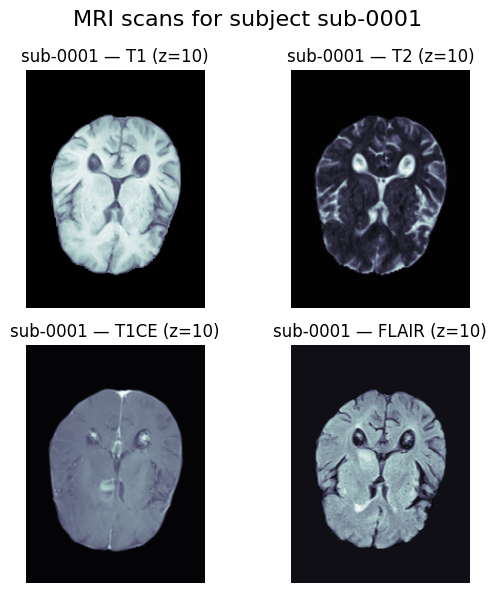

In [7]:
def show_four_from_scans(scans_dict, id, order=("t1","t2","t1ce","flair")):
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    axes = axes.ravel()
    for ax, mod in zip(axes, order):
        img = scans_dict[id].get(mod)
        z = img.shape[2] // 2               # middle axial slice
        sl = img[:, :, z]

        ax.imshow(sl.T, origin="lower", cmap="bone")
        ax.set_title(f"{id} — {mod.upper()} (z={z})")
        ax.axis("off")
    plt.suptitle(f"MRI scans for subject {id}", fontsize=16)
    plt.tight_layout()
    plt.show()

show_four_from_scans(scans, "sub-0001")

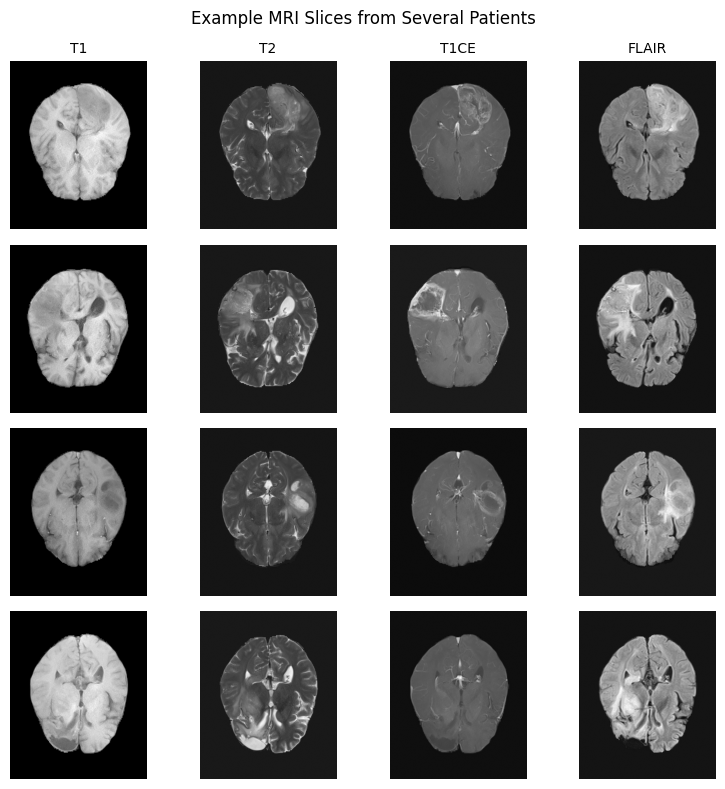

In [8]:
example_patients = list(scans.keys())[4:8]  # sub 5 to 8

fig, axes = plt.subplots(len(example_patients), 4, figsize=(8, 8))
modalities = ["t1", "t2", "t1ce", "flair"]

for i, sub in enumerate(example_patients):
    for j, mod in enumerate(modalities):
        img = scans[sub].get(mod)
        z = img.shape[2] // 2               # middle axial slice
        sl = img[:, :, z]

        ax = axes[i, j]
        ax.imshow(sl.T, origin="lower", cmap="gray")
        if i == 0:
            ax.set_title(mod.upper(), fontsize=10)
        if j == 0:
            ax.set_ylabel(sub, rotation=0, labelpad=40, fontsize=9)
        ax.axis("off")

plt.suptitle("Example MRI Slices from Several Patients", fontsize=12)
plt.tight_layout()
plt.show()

#### Segmentation data
In addition to the MRI images, the MOTUM dataset provides segmentation masks that delineate tumor regions on specific modalities. Two types of segmentations are available for each patient:
- **FLAIR segmentation (Label 1):** Highlights the edema and infiltrative regions surrounding the tumor, best visualized on FLAIR images where cerebrospinal fluid (CSF) signal is suppressed.
- **T1-contrast-enhanced (T1-CE) segmentation (Label 2):** Identifies the enhancing tumor core that takes up contrast agent, corresponding to areas of disrupted blood–brain barrier and active tumor tissue.  
The mask has the same spatial dimensions (x, y, z) as the corresponding MRI sequence it was derived from (e.g., FLAIR or T1CE), so each voxel in the mask aligns spatially with the same voxel in the image. The mask is a binary image where each voxel has a value of 1 (indicates that the voxel belongs to the segmented tumor region) or 0 (background or non-tumor tissue).

Visualizing these masks overlaid on the original MRI images allows us to verify alignment between scans and segmentations, inspect tumor morphology, and understand how the different modalities capture complementary biological information.

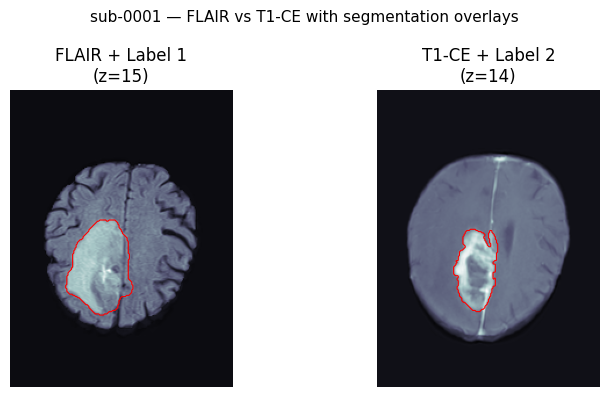

In [9]:
def show_mask_side_by_side(data_path, sub):
    """Show FLAIR and T1-CE images with their segmentation masks side-by-side."""
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    titles = ["FLAIR + Label 1", "T1-CE + Label 2"]
    modalities = ["flair", "t1ce"]
    masks = ["flair_seg_label1.nii.gz", "t1ce_seg_label2.nii.gz"]

    for ax, mod, mask_name, title in zip(axes, modalities, masks, titles):
        img_path = os.path.join(data_path, sub, "anat", f"{sub}_{mod}.nii.gz")
        mask_path = os.path.join(data_path, "derivatives", sub, mask_name)

        if not (os.path.exists(img_path) and os.path.exists(mask_path)):
            ax.axis("off")
            ax.set_title(f"{title}\n(missing)")
            continue

        img = nib.load(img_path).get_fdata(dtype=np.float32)
        mask = nib.load(mask_path).get_fdata(dtype=np.float32)
        z = int(np.argmax((mask > 0).sum(axis=(0, 1))))  # slice with largest mask
        sl = img[:, :, z]
        m = mask[:, :, z] > 0
        

        ax.imshow(sl.T, origin="lower", cmap="bone")
        ax.contour(m.T, colors="red", linewidths=0.8)
        ax.set_title(f"{title}\n(z={z})")
        ax.axis("off")

    plt.suptitle(f"{sub} — FLAIR vs T1-CE with segmentation overlays", fontsize=11)
    plt.tight_layout()
    plt.show()


show_mask_side_by_side(data_path, "sub-0001")

From the binary segmentation masks, we can obtain the tumor volume for each subject by multiplying the number of voxels labeled as tumor (value = 1) by the physical volume of a single voxel (derived from the image header). The result is expressed in cubic milimeters (mm3) which can also be converted to cm3. This measurement is biologically meaningful because it reflects tumor burden — larger volumes can indicate more aggressive disease or later detection. 

In [10]:
# compute the mask volume for all subjects
mask_volumes = []
masks = {
    "flair": "flair_seg_label1.nii.gz",
    "t1ce": "t1ce_seg_label2.nii.gz"
}

for sub in scans.keys():
    sub_data = {"Subject": sub, "FLAIR_Volume_mm3": np.nan, "T1CE_Volume_mm3": np.nan}
    
    for mod, mfile in masks.items():
        mask_path = os.path.join(data_path, "derivatives", sub, mfile)
        if os.path.exists(mask_path):
            img = nib.load(mask_path)
            mask = img.get_fdata(dtype=np.float32)
            voxel_volume = np.prod(img.header.get_zooms())  # mm³ per voxel
            mask_volume = (mask > 0).sum() * voxel_volume  # total mm³
            mask_volume_cm = mask_volume / 1000  # convert to cm³
            if mod == "flair":
                sub_data["FLAIR_Volume_mm3"] = mask_volume
                sub_data["FLAIR_Volume_cm3"] = mask_volume_cm
            else:
                sub_data["T1CE_Volume_mm3"] = mask_volume
                sub_data["T1CE_Volume_cm3"] = mask_volume_cm

    mask_volumes.append(sub_data)

mask_volumes_df = pd.DataFrame(mask_volumes)

mask_volumes_df = pd.DataFrame(mask_volumes)
mask_volumes_df.head()
# mask_volumes_df.describe()

,Subject,FLAIR_Volume_mm3,T1CE_Volume_mm3,FLAIR_Volume_cm3,T1CE_Volume_cm3
0,sub-0001,123623.916698,53049.479946,123.623917,53.049480
1,sub-0002,17240.621492,12048.044424,17.240621,12.048044
2,sub-0003,95350.374905,49696.672529,95.350375,49.696673
3,sub-0004,77804.302151,58714.457107,77.804302,58.714457
4,sub-0005,152714.230083,41933.525781,152.714230,41.933526


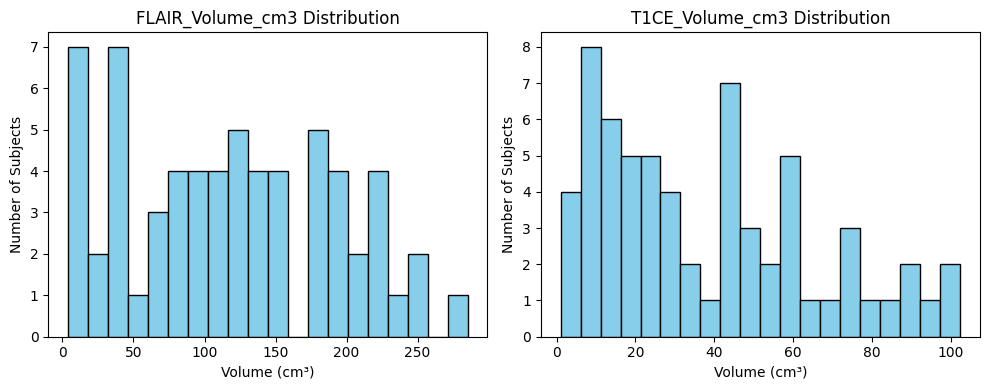

In [11]:
#
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.ravel()
for ax, mod in zip(axes, ["FLAIR_Volume_cm3", "T1CE_Volume_cm3"]):
    data = mask_volumes_df[mod]
    ax.hist(data, bins=20, color="skyblue", edgecolor="black")
    ax.set_title(f"{mod} Distribution")
    ax.set_xlabel("Volume (cm³)")
    ax.set_ylabel("Number of Subjects")
plt.tight_layout()
plt.show()

In this dataset, FLAIR-derived tumor volumes are generally larger, reflecting both the tumor and surrounding edema, while the T1CE volumes are smaller and more localized. This difference illustrates how each MRI modality captures distinct biological aspects of tumor pathology

### Radiomics data  
Radiomics data contains quantitative features extracted from MRI images which includes information such as about tumor intensity, texture and shape. These features can help identify patterns on tumor appearance. 

In [12]:
example_sub = "sub-0001"
example_file = os.path.join(data_path, "derivatives", example_sub, "flair_radiomics.csv")

# Find the line that starts with 'Image' (the header)
with open(example_file, "r") as f:
    lines = [line for line in f if line.strip()]

# Grab the header and the first data row after it
header_idx = next(i for i, line in enumerate(lines) if line.startswith("Image"))
clean_lines = lines[header_idx : header_idx + 2]

from io import StringIO
df = pd.read_csv(StringIO("".join(clean_lines)))
print("Shape:", df.shape)
df.head(3)


Shape: (1, 131)


,Image,Mask,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,/hdd3/bran/data/SD_glioma/submitted_data/MOTUM...,v3.0.1,1.19.5,2.1.1.2,1.1.1,3.6.9,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},9af757940deb27944b76de29e945ef711ea8c3f4,...,250.662852,0.002858,6.74482,0.131635,5185.291306,1.640657,0.000491,992.425231,0.03518,0.35631


In [13]:
df.columns

Index(['Image', 'Mask', 'diagnostics_Versions_PyRadiomics',
       'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK',
       'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python',
       'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Hash',
       ...
       'original_glszm_SmallAreaHighGrayLevelEmphasis',
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage',
       'original_glszm_ZoneVariance', 'original_ngtdm_Busyness',
       'original_ngtdm_Coarseness', 'original_ngtdm_Complexity',
       'original_ngtdm_Contrast', 'original_ngtdm_Strength'],
      dtype='object', length=131)

The radiomics data for each subject has already been processed using the package PyRadiomics. The data contains both diagnostics and radiomics features. We will keep only the radiomics features. These features can also be grouped into feature families:   
- **Shape:** Volume, surface area, sphericity, compactness, and elongation. These describe how irregular or compact the tumor is.
- **First order:** Describe basic intensity statistics within the tumor region,  such as mean, median, variance, skewness, and kurtosis. These summarize how bright or dark the tumor appears overall.
- **GLCM (Gray Level Co-occurrence Matrix):** Capture texture patterns by measuring how often pairs of intensity values occur together. These indicate heterogeneity and tells whether the tumor looks smooth or grainy. 
- **GLDM (Gray Level Dependence Matrix):** Measure how intensity values depend on their neighbors. This is useful for quantifying fine-grained texture and homogeneity.
- **GLRLM (Gray Level Run Length Matrix):** Quantify runs of similar gray-level pixels by describing how long uniform regions extend in the image.
- **GLSZM (Gray Level Size Zone Matrix):** Characterize clusters of connected pixels with the same intensity by measuring how large and how frequent these zones are
- **NGTDM (Neighboring Gray Tone Difference Matrix):** Assess the contrast and coarseness of the tumor texture. It tell us how much local intensity differs from its neighborhood.

In [14]:
def safe_read_radiomics(fpath):
    """Read a PyRadiomics CSV file safely — keeps only 1 header + 1 data row."""
    with open(fpath, "r") as f:
        lines = [line for line in f if line.strip()]
    # find the real header
    header_idx = next(i for i, line in enumerate(lines) if line.startswith("Image"))
    clean_lines = lines[header_idx : header_idx + 2]  # header + first data line
    return pd.read_csv(StringIO("".join(clean_lines)))


radiomics_data = []

for sub in id:
    sub_dir = os.path.join(data_path, "derivatives", sub)
    if not os.path.exists(sub_dir):
        continue

    for mod in ["flair", "t1", "t2", "t1ce"]:
        fpath = os.path.join(sub_dir, f"{mod}_radiomics.csv")
        if os.path.exists(fpath):
            df = safe_read_radiomics(fpath)
            # keep only numeric radiomics features (drop diagnostics columns)
            num_cols = [c for c in df.columns if c.startswith("original_")]
            df = df[num_cols].select_dtypes(include="number")
            df["subject"] = sub
            df["modality"] = mod
            radiomics_data.append(df)


radiomics_df = pd.concat(radiomics_data, ignore_index=True)
radiomics_df.columns = radiomics_df.columns.str.replace('original_', '', regex=False)
print("Combined radiomics table:")
print(radiomics_df.shape)
radiomics_df.head()


Combined radiomics table:
(268, 109)


,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,shape_MeshVolume,shape_MinorAxisLength,...,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength,subject,modality
0,0.681718,0.550436,43.676621,79.349148,74.962746,96.794335,80.951374,97.247282,123210.853297,54.093721,...,6.744820,0.131635,5185.291306,1.640657,0.000491,992.425231,0.035180,0.356310,sub-0001,flair
1,0.681718,0.550436,43.676621,79.349148,74.962746,96.794335,80.951374,97.247282,123210.853297,54.093721,...,6.548258,0.041319,55673.143828,6.749277,0.000436,173.207251,0.021267,0.085133,sub-0001,t1
2,0.681718,0.550436,43.676621,79.349148,74.962746,96.794335,80.951374,97.247282,123210.853297,54.093721,...,7.296700,0.308667,85.146194,1.141251,0.000461,6241.451443,0.101522,0.852954,sub-0001,t2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sub-0001,t1ce
4,0.913314,0.814380,26.662496,32.739619,42.267001,40.812064,61.197426,62.460987,17096.773431,29.901541,...,6.369618,0.165987,1505.866718,1.269290,0.001288,664.713975,0.145443,0.409957,sub-0002,flair


The radiomics dataframe now contain the radiomics data for each of the 4 MRI modalities for each subject. Now we can look at the number of feature in each feature family

In [15]:
feature_families = {}
for c in radiomics_df.columns:
    if c == "subject" or c == "modality":
        continue
    fam = c.split("_")[0]
    # if fam in feature_families:
    #     feature_families[fam] += 1
    # else:
    #     feature_families[fam] = 1
    feature_families[fam] = feature_families.get(fam, 0) + 1
# Number of feature in each feature family
feature_families

{'shape': 14,
 'firstorder': 18,
 'glcm': 24,
 'gldm': 14,
 'glrlm': 16,
 'glszm': 16,
 'ngtdm': 5}

In [16]:
num_df = radiomics_df.select_dtypes(include=["number"]).drop(columns=["subject"], errors="ignore")
num_df.describe().T

,count,mean,std,min,25%,50%,75%,max
shape_Elongation,195.0,0.743831,0.138219,0.357788,0.693929,0.769269,0.839058,9.881881e-01
shape_Flatness,195.0,0.580123,0.134756,0.157711,0.509198,0.597354,0.663100,8.227537e-01
shape_LeastAxisLength,195.0,43.307321,11.355896,15.124435,33.573927,46.044713,51.958599,6.283381e+01
shape_MajorAxisLength,195.0,80.417877,31.496527,19.340772,59.975373,77.610781,93.980145,1.857598e+02
shape_Maximum2DDiameterColumn,195.0,77.442044,22.385123,24.487246,63.243344,76.147945,86.702091,1.411524e+02
...,...,...,...,...,...,...,...,...
ngtdm_Busyness,195.0,6.835923,17.757748,0.070924,1.404392,2.634228,6.744399,2.143777e+02
ngtdm_Coarseness,195.0,0.000638,0.001171,0.000050,0.000171,0.000257,0.000455,7.549449e-03
ngtdm_Complexity,195.0,14503.502312,101684.906571,11.481012,378.975061,851.224379,5399.555658,1.326078e+06
ngtdm_Contrast,195.0,0.129202,0.183019,0.004683,0.033954,0.064077,0.128264,1.129726e+00


In [17]:
num_df.head()

,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,shape_MeshVolume,shape_MinorAxisLength,...,glszm_SmallAreaHighGrayLevelEmphasis,glszm_SmallAreaLowGrayLevelEmphasis,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength
0,0.681718,0.550436,43.676621,79.349148,74.962746,96.794335,80.951374,97.247282,123210.853297,54.093721,...,250.662852,0.002858,6.744820,0.131635,5185.291306,1.640657,0.000491,992.425231,0.035180,0.356310
1,0.681718,0.550436,43.676621,79.349148,74.962746,96.794335,80.951374,97.247282,123210.853297,54.093721,...,79.483985,0.005339,6.548258,0.041319,55673.143828,6.749277,0.000436,173.207251,0.021267,0.085133
2,0.681718,0.550436,43.676621,79.349148,74.962746,96.794335,80.951374,97.247282,123210.853297,54.093721,...,404.492261,0.001706,7.296700,0.308667,85.146194,1.141251,0.000461,6241.451443,0.101522,0.852954
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.913314,0.814380,26.662496,32.739619,42.267001,40.812064,61.197426,62.460987,17096.773431,29.901541,...,118.528081,0.011800,6.369618,0.165987,1505.866718,1.269290,0.001288,664.713975,0.145443,0.409957


### Correlation   
Before doing correlation, we see that the num_df contains some `NaN` which correspond to the t1ce modality. Also, the shape features seem to be the same across the other 3 modalities. This is because the shape features are obtained from the same segmented tumor region across modalities, which does not represent pixel intensities. 


In [18]:
num_df = num_df.dropna()
num_df.tail(20)

,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,shape_MeshVolume,shape_MinorAxisLength,...,glszm_SmallAreaHighGrayLevelEmphasis,glszm_SmallAreaLowGrayLevelEmphasis,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength
241,0.844609,0.587609,31.231296,53.149812,56.707341,57.622152,60.619362,60.995163,50405.029173,44.890825,...,146.267855,0.009368,6.101389,0.050325,15750.754831,2.401576,0.000822,304.493601,0.071832,0.241459
242,0.844609,0.587609,31.231296,53.149812,56.707341,57.622152,60.619362,60.995163,50405.029173,44.890825,...,486.523537,0.002793,7.194969,0.280152,199.220006,1.276865,0.000599,6147.140660,0.634385,0.844611
244,0.357788,0.239337,31.457684,131.436688,57.706995,64.572148,97.559617,113.847238,34196.733565,47.026506,...,115.106607,0.003022,6.779557,0.099074,1285.984081,2.264255,0.000817,458.794591,0.055465,0.250153
245,0.357788,0.239337,31.457684,131.436688,57.706995,64.572148,97.559617,113.847238,34196.733565,47.026506,...,96.604585,0.007606,6.566858,0.062845,13595.405886,2.604289,0.000902,204.423202,0.040557,0.236989
246,0.357788,0.239337,31.457684,131.436688,57.706995,64.572148,97.559617,113.847238,34196.733565,47.026506,...,291.067336,0.005341,7.390975,0.300961,61.613413,1.166349,0.000790,5048.172242,0.128063,1.707951
248,0.748215,0.514750,30.752105,59.741849,83.450869,58.297158,82.798949,86.560713,44997.093719,44.699719,...,233.277671,0.002582,8.160252,0.080036,3143.145630,2.486541,0.000276,2205.858477,0.069629,0.278679
249,0.748215,0.514750,30.752105,59.741849,83.450869,58.297158,82.798949,86.560713,44997.093719,44.699719,...,35.475892,0.007333,7.084498,0.022050,154014.698951,17.047285,0.000255,148.338971,0.034547,0.034872
250,0.748215,0.514750,30.752105,59.741849,83.450869,58.297158,82.798949,86.560713,44997.093719,44.699719,...,82.006849,0.005485,7.359938,0.069215,8579.298338,10.853258,0.000247,653.184783,0.041902,0.119485
252,0.784864,0.673074,31.374326,46.613453,54.786515,46.703853,53.123088,57.393921,33578.019658,36.585238,...,264.608576,0.002635,7.060124,0.120912,1007.511694,0.960997,0.000882,1105.504651,0.035179,0.657468
253,0.784864,0.673074,31.374326,46.613453,54.786515,46.703853,53.123088,57.393921,33578.019658,36.585238,...,218.545587,0.003367,6.334917,0.084774,12881.678314,1.472194,0.000757,467.303580,0.014292,0.490931


We observe that the shape features have the same value irrespective of the subject or modality and tumor type. Therefore the shape features are not informative and will be removed from the radiomics data. 

In [19]:
# show the number of unique values for shape features
num_df.filter(like="shape").nunique()

shape_Elongation                 67
shape_Flatness                   67
shape_LeastAxisLength            67
shape_MajorAxisLength            67
shape_Maximum2DDiameterColumn    67
shape_Maximum2DDiameterRow       67
shape_Maximum2DDiameterSlice     66
shape_Maximum3DDiameter          67
shape_MeshVolume                 67
shape_MinorAxisLength            67
shape_Sphericity                 67
shape_SurfaceArea                67
shape_SurfaceVolumeRatio         67
shape_VoxelVolume                67
dtype: int64

All shape features have 1 unique value, confirming that the shape feature is the same across the dataset. 

In [20]:
num_df = num_df.drop(columns=num_df.filter(like="shape").columns, axis=1)
num_df

,firstorder_10Percentile,firstorder_90Percentile,firstorder_Energy,firstorder_Entropy,firstorder_InterquartileRange,firstorder_Kurtosis,firstorder_Maximum,firstorder_MeanAbsoluteDeviation,firstorder_Mean,firstorder_Median,...,glszm_SmallAreaHighGrayLevelEmphasis,glszm_SmallAreaLowGrayLevelEmphasis,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength
0,400.0,641.0,6.052428e+09,3.930140,143.0,4.941571,914.0,80.109264,529.376860,542.0,...,250.662852,0.002858,6.744820,0.131635,5185.291306,1.640657,0.000491,992.425231,0.035180,0.356310
1,490.0,617.0,6.295927e+09,3.059509,64.0,4.322819,741.0,39.626703,547.241866,543.0,...,79.483985,0.005339,6.548258,0.041319,55673.143828,6.749277,0.000436,173.207251,0.021267,0.085133
2,349.0,843.0,8.225289e+09,4.963778,274.0,3.413399,1602.0,156.228037,597.823544,589.0,...,404.492261,0.001706,7.296700,0.308667,85.146194,1.141251,0.000461,6241.451443,0.101522,0.852954
4,262.0,506.0,8.821682e+08,3.724322,106.0,5.495189,629.0,82.903851,408.682912,446.0,...,118.528081,0.011800,6.369618,0.165987,1505.866718,1.269290,0.001288,664.713975,0.145443,0.409957
5,397.0,585.0,1.256929e+09,3.561431,71.0,4.771026,819.0,57.260221,499.626631,509.0,...,83.331845,0.019726,6.445739,0.124388,2910.690255,1.477028,0.001681,357.901006,0.057831,0.393454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,452.0,605.0,5.045108e+09,3.320442,78.0,3.739796,733.0,48.025699,532.604638,537.0,...,172.253706,0.003008,6.445812,0.090080,10698.650100,3.611826,0.000440,409.064889,0.026802,0.163836
262,101.0,663.0,3.633656e+09,4.895988,365.0,2.008327,1142.0,180.863304,402.969460,442.0,...,292.706018,0.004260,7.153459,0.303174,333.248652,3.192036,0.000377,3743.846702,0.295454,0.347261
264,483.0,766.0,1.655078e+10,4.334025,155.0,4.712665,1026.0,97.708932,626.748088,633.0,...,291.738829,0.002449,7.391013,0.116613,3927.769366,2.607406,0.000253,1505.315618,0.054442,0.235595
265,659.0,1149.0,3.027391e+10,4.664187,168.0,6.534626,2083.0,158.870529,832.928651,790.0,...,1014.273141,0.001240,7.910626,0.158388,6813.765878,1.110168,0.000235,8846.410131,0.084442,0.988263


In [21]:
corr = num_df.corr()

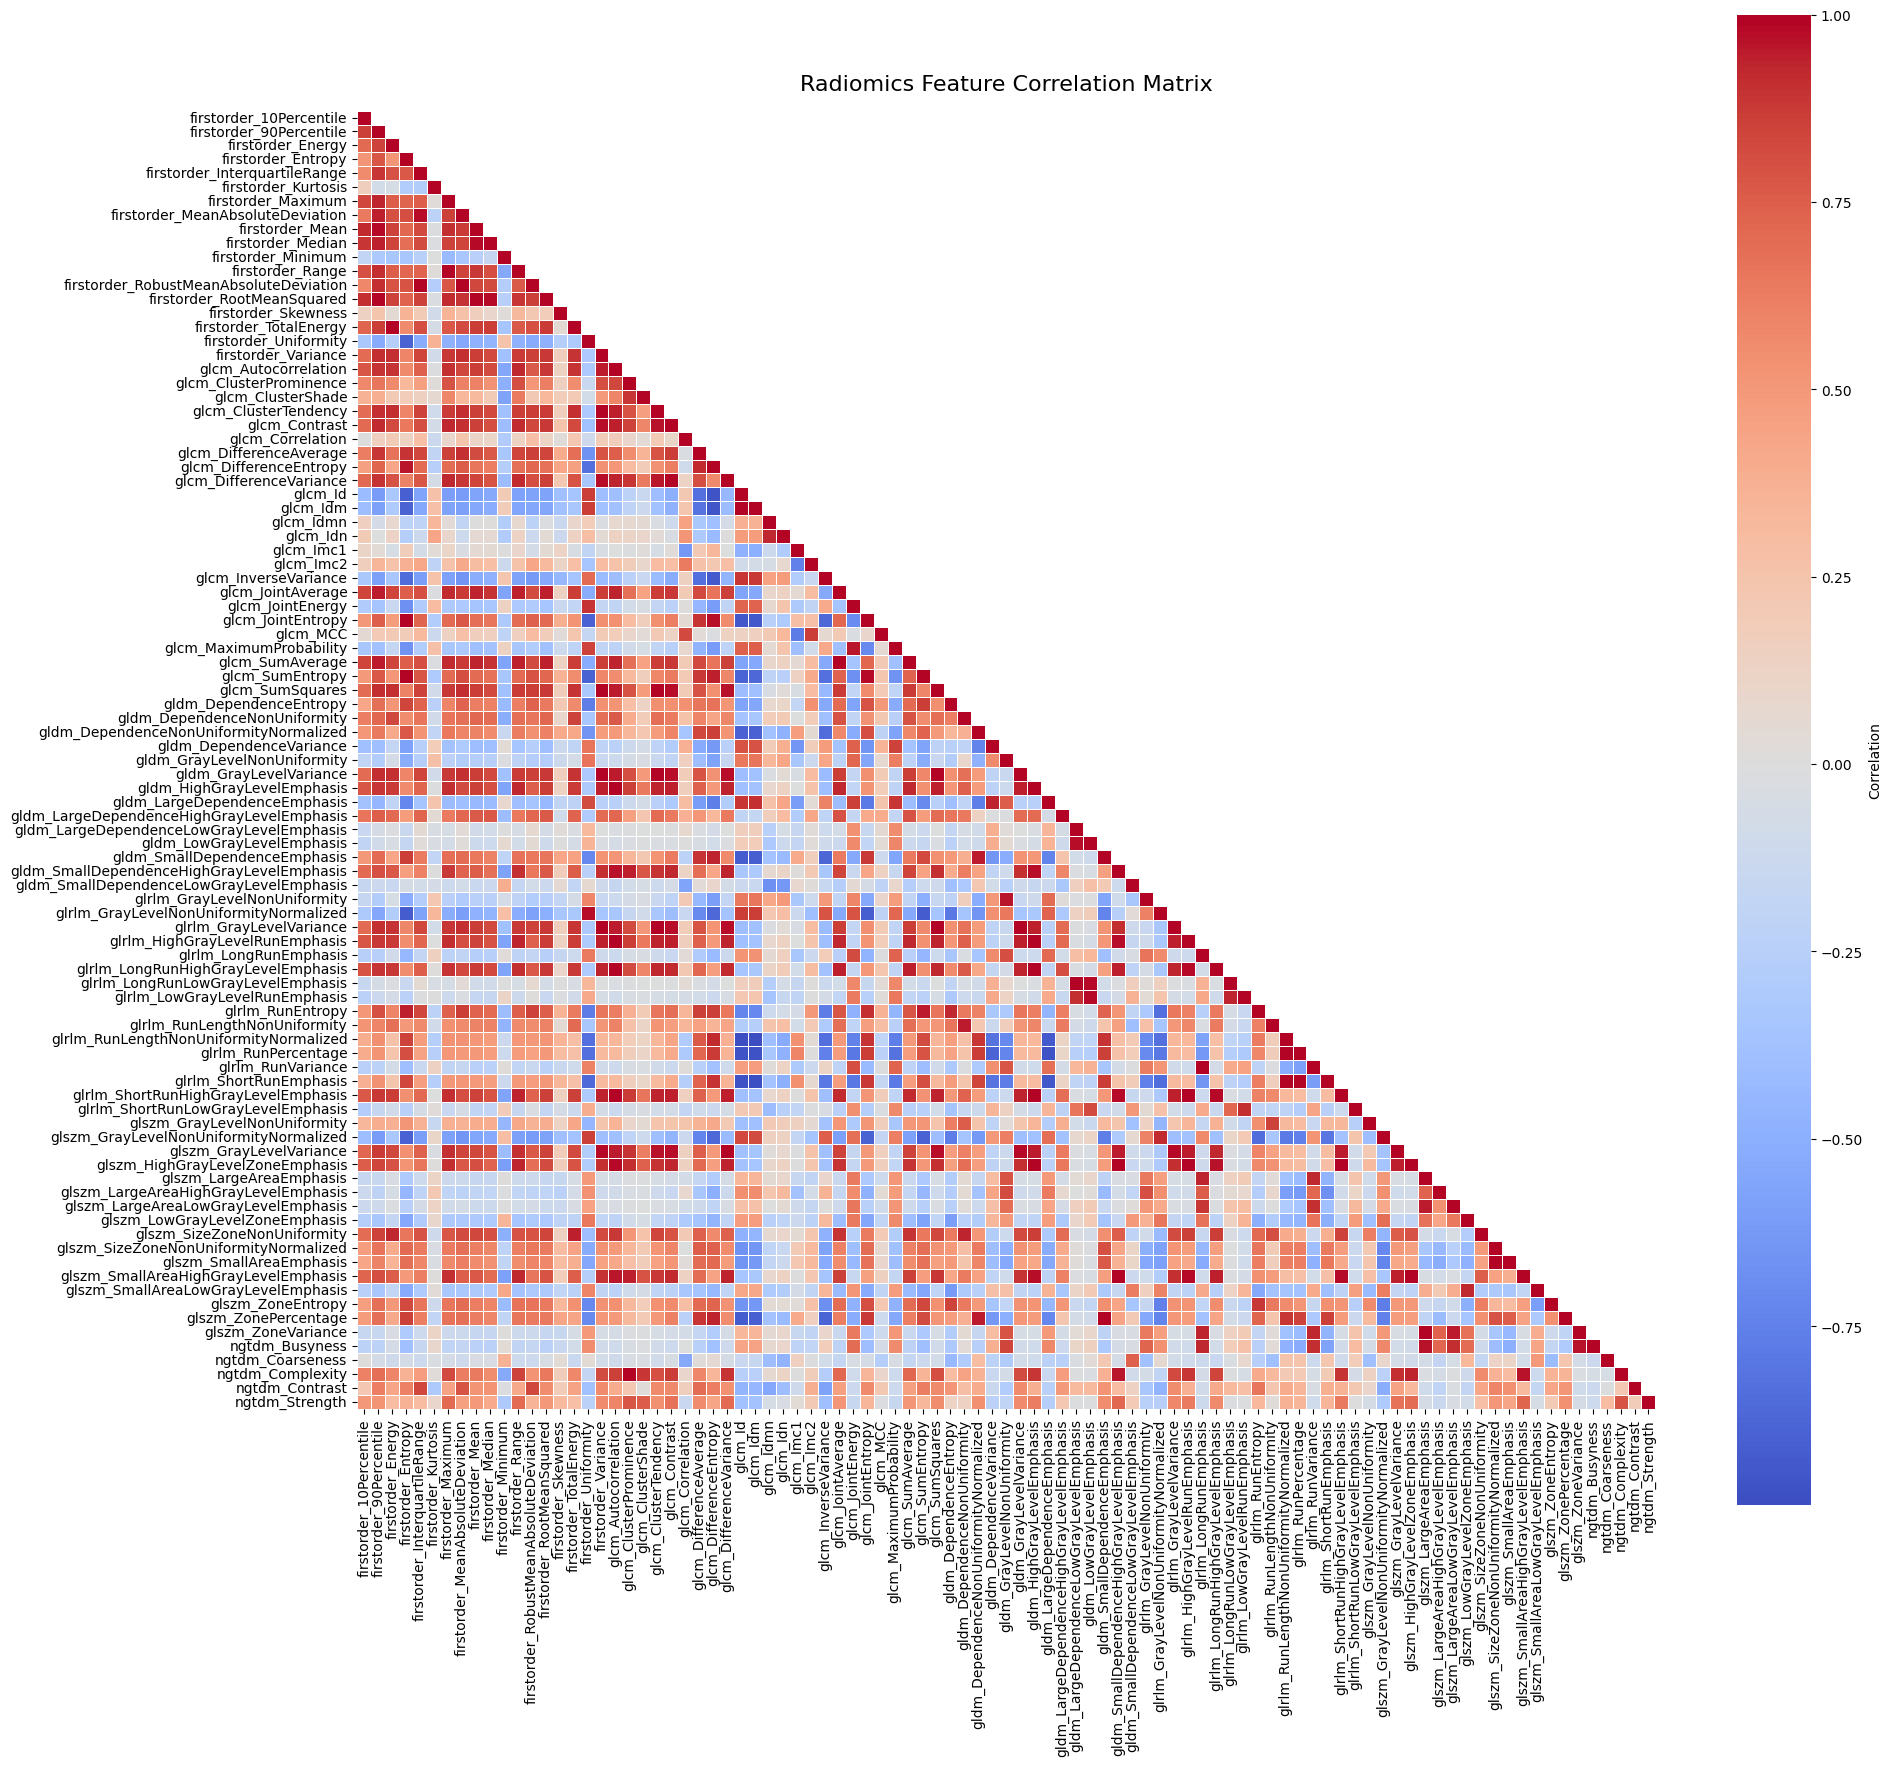

In [22]:
def get_lower_tri_heatmap(df):
    #https://stackoverflow.com/questions/2318529/plotting-only-upper-lower-triangle-of-a-heatmap
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = False

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 18))

    # # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_plot = sns.heatmap(df, mask=mask, cmap="coolwarm", center=0,
            square=True, linewidths=.5, cbar_kws={"label": "Correlation"},
            xticklabels=corr.columns, yticklabels=corr.columns)
    return sns_plot

get_lower_tri_heatmap(corr)
plt.title("Radiomics Feature Correlation Matrix", fontsize=16, pad=15)
plt.tight_layout()
plt.show()

In [23]:
corr

,firstorder_10Percentile,firstorder_90Percentile,firstorder_Energy,firstorder_Entropy,firstorder_InterquartileRange,firstorder_Kurtosis,firstorder_Maximum,firstorder_MeanAbsoluteDeviation,firstorder_Mean,firstorder_Median,...,glszm_SmallAreaHighGrayLevelEmphasis,glszm_SmallAreaLowGrayLevelEmphasis,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength
firstorder_10Percentile,1.000000,0.852548,0.711995,0.512677,0.563438,0.168181,0.833327,0.636904,0.921452,0.890124,...,0.724156,-0.241114,0.471225,0.481531,-0.151361,-0.225889,0.013175,0.608476,0.225536,0.499882
firstorder_90Percentile,0.852548,1.000000,0.845431,0.779394,0.883500,-0.082828,0.934929,0.941660,0.978332,0.941658,...,0.813588,-0.328497,0.675377,0.680576,-0.152984,-0.223093,-0.065126,0.684889,0.612780,0.524919
firstorder_Energy,0.711995,0.845431,1.000000,0.517431,0.791349,-0.049125,0.756532,0.803806,0.845540,0.842903,...,0.752834,-0.183921,0.501051,0.414768,-0.037742,-0.068040,-0.105229,0.592075,0.435038,0.301691
firstorder_Entropy,0.512677,0.779394,0.517431,1.000000,0.774192,-0.284134,0.721416,0.813579,0.714442,0.683298,...,0.489527,-0.526450,0.825680,0.853220,-0.302006,-0.385106,-0.076664,0.368421,0.609433,0.368350
firstorder_InterquartileRange,0.563438,0.883500,0.791349,0.774192,1.000000,-0.279050,0.747491,0.972158,0.822934,0.813669,...,0.616343,-0.301781,0.650722,0.613776,-0.116032,-0.162713,-0.115213,0.476735,0.829366,0.305715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ngtdm_Busyness,-0.225889,-0.223093,-0.068040,-0.385106,-0.162713,0.086600,-0.197447,-0.179420,-0.233710,-0.227813,...,-0.081166,0.435293,-0.171833,-0.300852,0.962003,1.000000,-0.133606,-0.050273,-0.127066,-0.115550
ngtdm_Coarseness,0.013175,-0.065126,-0.105229,-0.076664,-0.115213,-0.030098,-0.065418,-0.106790,-0.040749,-0.039303,...,-0.080534,0.490605,-0.419578,0.231276,-0.078323,-0.133606,1.000000,-0.053450,-0.017067,0.305547
ngtdm_Complexity,0.608476,0.684889,0.592075,0.368421,0.476735,0.025594,0.824729,0.625758,0.635832,0.553732,...,0.962514,-0.117890,0.354237,0.355133,-0.025401,-0.050273,-0.053450,1.000000,0.228220,0.786842
ngtdm_Contrast,0.225536,0.612780,0.435038,0.609433,0.829366,-0.311509,0.442108,0.786674,0.519255,0.520753,...,0.309360,-0.165669,0.428082,0.516343,-0.101133,-0.127066,-0.017067,0.228220,1.000000,0.185318


The heatmap shows the pairwise Pearson correlation between all radiomics features after removing the constant shape features. Strong correlations (red blocks) indicate that many features within the same family capture overlapping information about the tumor. The presence of high inter-feature correlations shows the redundancy commonly found in radiomics data. Therefore there is a need for feature selection or dimensionality reduction techniques (e.g., PCA, LASSO, or Random Forest importance) before training machine learning models, ensuring that only the most informative and non-redundant features contribute to tumor classification.

In [24]:
# path to save outputs
output_path = os.path.join("/home/btchatch/links/scratch/mri", "outputs")
if not os.path.exists(output_path):
    os.makedirs(output_path)

# save the correlation matrix to a CSV file
corr.to_csv(os.path.join(output_path, "radiomics_feature_correlation_matrix.csv"))

# save radiomics_df without the t1ce modality
x = radiomics_df.drop(columns=radiomics_df.filter(like="shape").columns, axis=1)
x.dropna().to_csv(os.path.join(output_path, "combined_radiomics_features.csv"), index=False)

# save scans dictionary as a pickle file
import pickle
with open(os.path.join(output_path, "mri_scans.pkl"), "wb") as f:
    pickle.dump(scans, f)
    

In [25]:
output_path

'/home/btchatch/links/scratch/mri/outputs'